## **CycleGAN 실습에 필요한 파이썬 라이브러리를 불러옵니다.** 

In [0]:
# pyTorch 관련 된 라이브러리.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # optimization에 관한 모듈.
import torchvision # 이미지 관련 전처리, pretrained된 모델, 데이터 로딩에 관한 패키지입니다.
import torchvision.datasets as datasets
import torchvision.transforms as T # 이미지 전처리 모듈입니다.
from torch.utils import data

# 기타 필요한 라이브러리.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import time
import datetime

### cycleGAN

![image.png](attachment:image.png)

구조에 대한 간단한 리뷰

## Training에 사용될 Hyper-parameter를 지정합니다.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # tensor.to(device) 방식을 통해서 cpu -> gpu로 보낼 수 있습니다.
lr = 0.0002 # learning rate 
batch_size = 128 # 한번에 들어갈 배치 수 

## Training에 사용될 데이터를 불러옵니다.
cycleGAN의 경우 두 가지 서로 다른 도메인의 데이터(MNIST, SVHN)가 필요합니다. 모델이 트레이닝 된 이후에는 우리는 MNIST를 SVHN으로 바꾸거나 SVHN 데이터를 MNIST로 바꿀 수 있습니다.

In [0]:
'''
일반적으로 데이터 로딩을 할 때는 transforms를 통해서 일괄적으로 데이터 전처리를 해줍니다.
이 경우 데이터가 서로 다른 사이즈를 가지고 있기 때문에 (28 vs 32), 데이터 사이즈를 맞춰주겠습니다.

'''
transform = T.Compose([
    T.Resize(32), # 32 x 32로 변환
    T.ToTensor()])

In [0]:
# ========================  MNIST 데이터 함수. ======================== #

def MNIST_DATA(root='./data/', train=True, transforms=None, download=True, batch_size=32, num_worker=4):
    print ("[+] Get the MNIST DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다. 
    Machine Learning 에서 Hello world 라고 불리는 Mnist 데이터를 사용해 보겠습니다.
  
    """
    
    mnist_train = datasets.MNIST(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    mnist_test = datasets.MNIST(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = mnist_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train, mnist_test, trainDataLoader, testDataLoader


# ======================== SVHN 데이터 함수. ======================== #  

def SVHN_DATA(root='./data/',train=True, transforms=None, download =True, batch_size=32, num_worker=4):

    print ("[+] Get the SVHN DATA")
    """
    The Street View House Numbers(SVHN) 데이터 셋은 길거리에서 집 번호들을 찍은 데이터 셋 입니다. 
    SVHN은 MNIST와 마찬가지로 숫자 데이터셋이나 구조가 MNIST정도로 단순하지 않고 색깔 등이 있는 현실 이미지 입니다.
    """
    svhn_train = datasets.SVHN(root = root,  #root 는 데이터의 저장 위치 입니다. 
                               split = 'train', # SVHN 데이터의 경우 'split' argument로 train/test를 지정해 줍니다. 
                               transform = transform, # 얻어낸 데이터를 Resize 해주고, Tensor로 변환해 줍니다. 
                               download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 

    svhn_test = datasets.SVHN(root = root,
                              split = 'test',  # SVHN 데이터의 경우 'split' argument로 train/test를 지정해 줍니다. 
                              transform = transform,
                              download = True)
    
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    """
    trainDataLoader = data.DataLoader(dataset = svhn_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 꼭 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보입니다. 

    testDataLoader = data.DataLoader(dataset = svhn_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return svhn_train, svhn_test, trainDataLoader, testDataLoader

In [0]:
# Dataloader들을 불러옵니다.
mnist_trainset, mnist_testset, mnist_trainloader, mnist_testloader = MNIST_DATA(batch_size = batch_size) 
svhn_trainset, svhn_testset, svhn_trainloader, svhn_testloader = SVHN_DATA(batch_size = batch_size) 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing
[+] Get the SVHN DATA
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
[+] Finished loading data & Preprocessing


## 서로 다른 도메인의 데이터를 한번 확인해 봅시다.

In [0]:
def show_images_by_class(dataset, cmap=None):
    ''' 각 데이터 셋에서 0-9 숫자를 찾아서 프린트 해보겠습니다. '''
    per_class_index = []
    try:
        labels = dataset.targets # dataset의 레이블 정보를 배웁니다.
    except:
        labels = dataset.labels 
  
    for idx in range(10):
        try:
            per_class_index += [(labels == idx).nonzero()[1].item()]
        except:
            per_class_index += [(labels == idx).nonzero()[0][1].item()]

    images = dataset.data[torch.Tensor(per_class_index).long()]
  
    plt.figure(figsize=(16,160)) # 세로 사이즈 20, 가로 사이즈 20*10  
  
    for a in range(1, 11):      
        plt.subplot(1, 10, a)
        try:
            plt.imshow(images[a-1], cmap)
        except:
            plt.imshow(images[a-1].transpose(1,2,0), cmap)
        plt.xticks([])
        plt.yticks([])  
    plt.show()  

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f93cce67588>>
Traceback (most recent call last):
  File "/home/sunghyun/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/home/sunghyun/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/sunghyun/anaconda3/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


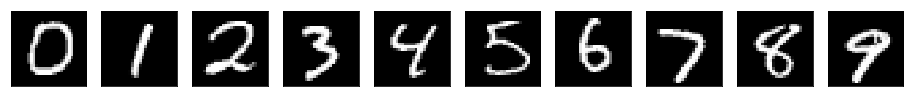

In [0]:
show_images_by_class(mnist_testset, plt.cm.gray)

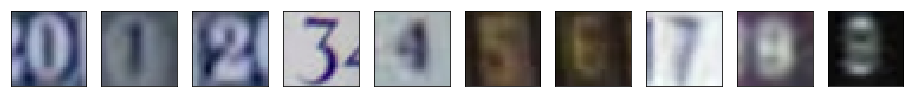

In [0]:
show_images_by_class(svhn_testset)

## 생성자 및 식별자 모델 생성 

In [0]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.05))
    if activation == 'tanh':
        layers.append(nn.Tanh())
    if activation == 'none':
        pass
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.05))
    if activation == 'tanh':
        layers.append(nn.Tanh())
    if activation == 'none':
        pass
                
    return nn.Sequential(*layers)

In [0]:
'''
Generator와 Discriminator를 선언해 줍니다. 
이 때 MNIST는 흑백 이미지이므로 채널이 1이라는 점과 SVHN은 컬러 이미지이므로 채널이 3이라는 것에 주의합니다!!! 
'''

class G(nn.Module):
    """ Generator. """
    def __init__(self, in_dim=1, out_dim=3):
        super(G, self).__init__()
        # encoding blocks
        self.conv1 = conv(in_dim, 64, 4) # (B, 64, 16, 16)
        self.conv2 = conv(?, ?, ?) # (B, 128, 8, 8)
        
        # intermediate blocks
        self.conv3 = conv(?, ?, ?, ?, ?) # (B, 128, 8, 8)
        self.conv4 = conv(?, ?, ?, ?, ?) # (B, 128, 8, 8)
        
        # decoding blocks
        self.deconv1 = deconv(?, ?, ?) # (B, 64, 16, 16)
        self.deconv2 = deconv(?, ?, ?, bn=False, activation='tanh') # (B, out_dim, 32, 32)
        
    def forward(self, x):
        out = self.conv1(x)      # (B, 64, 16, 16)
        out = self.conv2(out)    # (B, 128, 8, 8)
        
        out = self.conv3(out)    # (B, 128, 8, 8)
        out = self.conv4(out)    # (B, 128, 8, 8)
        
        out = self.deconv1(out)  # (B, 64, 16, 16)
        out = self.deconv2(out)  # (B, out_dim, 32, 32)
        return out


class D(nn.Module):
    """ Discriminator. """
    def __init__(self, in_dim=1):
        super(D, self).__init__()
        self.conv1 = conv(in_dim, 64, 4, bn=False) # (B, 64, 16, 16)
        self.conv2 = conv(64, 64*2, 4) # (B, 128, 8, 8)
        self.conv3 = conv(64*2, 64*4, 4) # (B, 256, 4, 4)
        self.fc = conv(64*4, 1, 4, 1, 0, bn=False, activation='none')
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.conv1(x)    # (B, 64, 16, 16)
        out = self.conv2(out)  # (B, 128, 8, 8)
        out = self.conv3(out)  # (B, 256, 4, 4)
        out = self.fc(out).squeeze()
        out = self.sigmoid(out)
        return out


## 학습을 위한 사전 모델/optimizer 선언 & 기타준비

In [0]:
# 모델 선언 및 train모드로 만들어 줍니다.
G_ms = G(in_dim=1, out_dim=3).train()
G_sm = G(in_dim=3, out_dim=1).train()
D_m = D(in_dim=1).train()
D_s = D(in_dim=3).train()

# 선언한 모델들을 GPU에서 사용할 수 있도록 해 줍니다.
G_ms = G_ms.to(device)
G_sm = G_sm.to(device)
D_m = D_m.to(device)
D_s = D_s.to(device)

# Optimizer 선언
g_optim = optim.Adam(list(G_ms.parameters()) + list(G_sm.parameters()), lr=lr, betas=(0.5, 0.99))
d_optim = optim.Adam(list(D_m.parameters()) + list(D_s.parameters()), lr=lr, betas=(0.5, 0.99))

# Iteration 수 선언
iters = 10000

# trainig 과정에서 생성되는 이미지가 어떻게 변화하는지 볼 수 있도록 고정된 데이터를 가지고 있으면 좋습니다.
mnist_iter = iter(mnist_testloader)
svhn_iter = iter(svhn_testloader)

# 각 도메인별로 2개만 생성해 보겠습니다 
fixed_mnist = next(mnist_iter)[0][:2].to(device)
fixed_svhn = next(svhn_iter)[0][:2].to(device)

# Fixed된 이미지를 프린팅하는 함수
def show_images(images):
    print_list = []
    for i in range(2):
        print_list += [images[0][i], images[1][i], images[2][i]]
  
    for i in range(2):
        print_list += [images[3][i], images[4][i], images[5][i]] 
    plt.figure(figsize=(8,14)) # 세로 사이즈 40, 가로 사이즈 20*3
  
    for a in range(1, 7):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])
    for a in range(7, 13):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])      
    plt.show()    

## Training CycleGAN 

여기서의 loss는 크게 4가지로 나누어 집니다.

- D: Real images들을 1로 분류하기 위한 loss (d_real_loss)
- D: Fake images들을 0로 분류하기 위한 loss (d_fake_loss)
- G: D를 속이는 Fake images들을 만들기 위한 loss (D에서 1로 분류함)(g_loss (1))
- G: 다시 돌아 갔을 때 reconstruction을 위한 cycle loss (g_loss (2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed [0:01:29.498687], Step [1000/10000], d_real_loss: 0.0218, d_fake_loss: 0.1395, g_loss: 1.0200


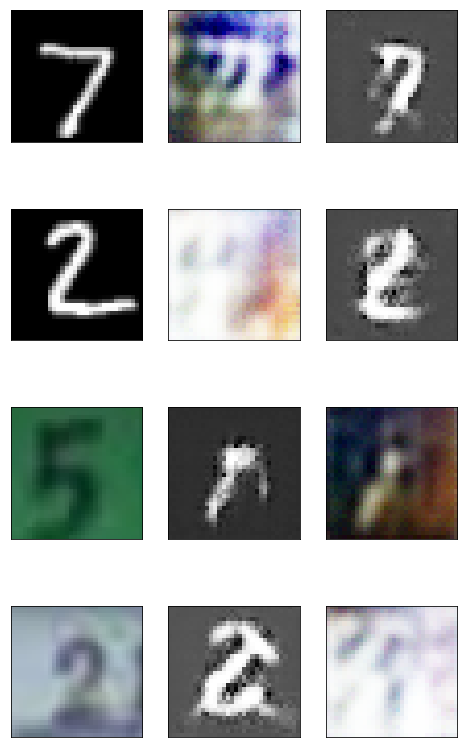

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed [0:03:00.841968], Step [2000/10000], d_real_loss: 0.3478, d_fake_loss: 0.0163, g_loss: 1.0220


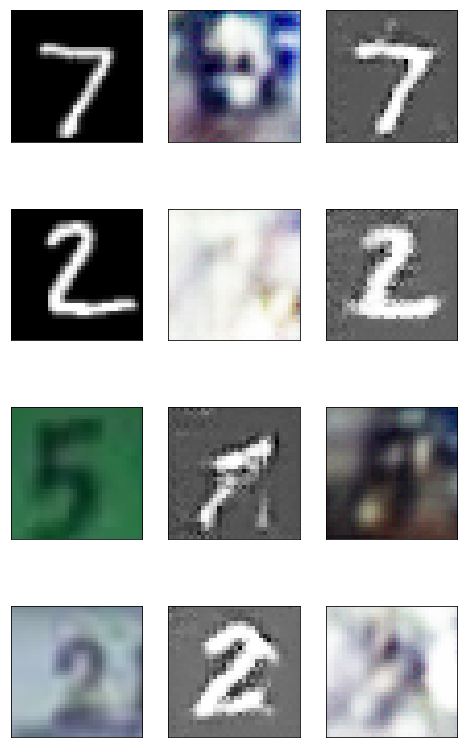

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed [0:04:32.578936], Step [3000/10000], d_real_loss: 0.0132, d_fake_loss: 0.0077, g_loss: 1.0151


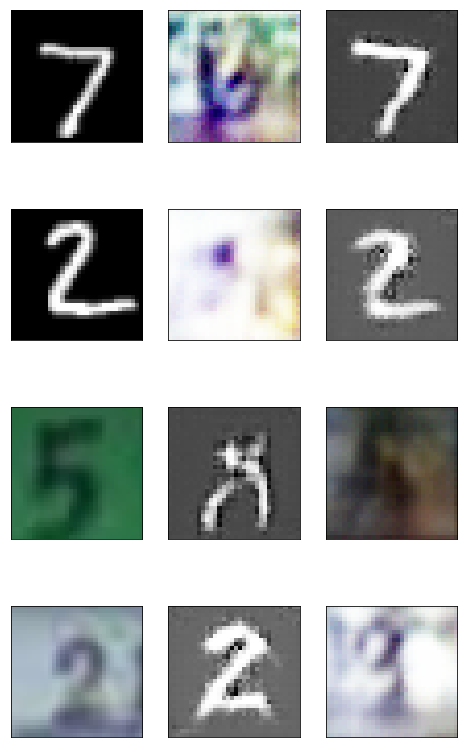

Elapsed [0:06:04.703227], Step [4000/10000], d_real_loss: 0.0019, d_fake_loss: 0.0066, g_loss: 1.0138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


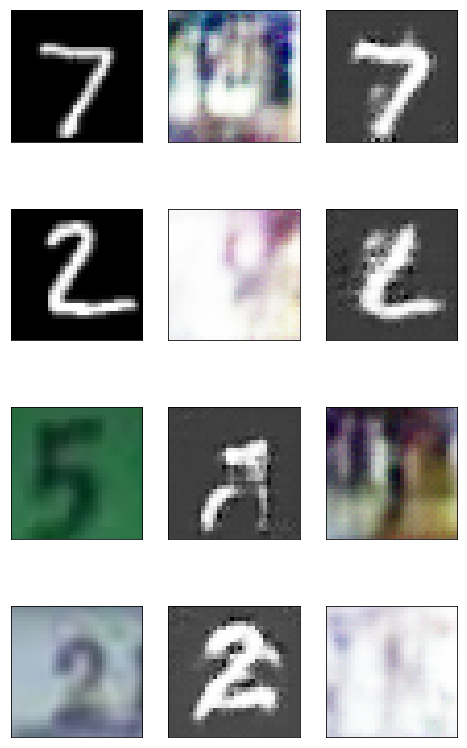

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed [0:07:36.476801], Step [5000/10000], d_real_loss: 0.0037, d_fake_loss: 0.0369, g_loss: 1.0099


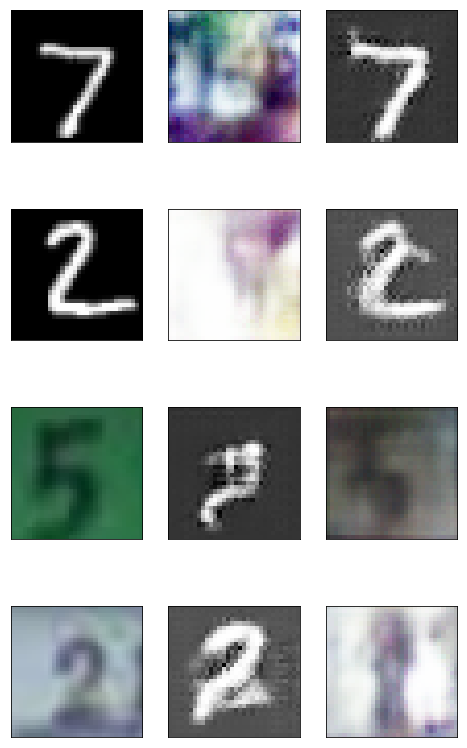

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed [0:09:09.542937], Step [6000/10000], d_real_loss: 0.0537, d_fake_loss: 0.0796, g_loss: 1.0078


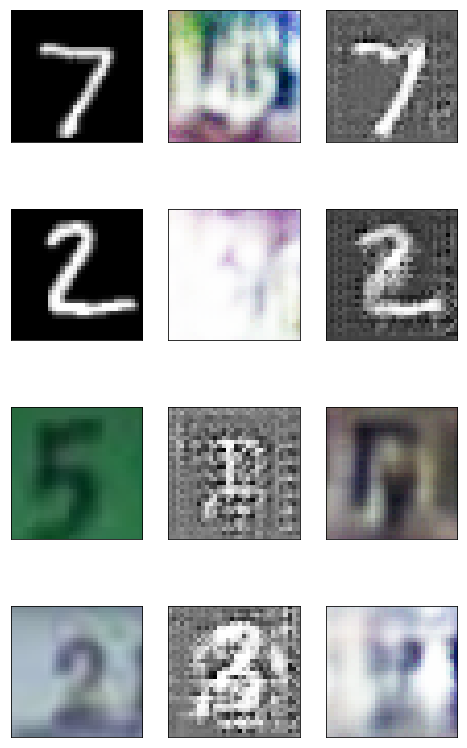

Elapsed [0:10:40.602554], Step [7000/10000], d_real_loss: 0.0011, d_fake_loss: 0.0497, g_loss: 1.0091


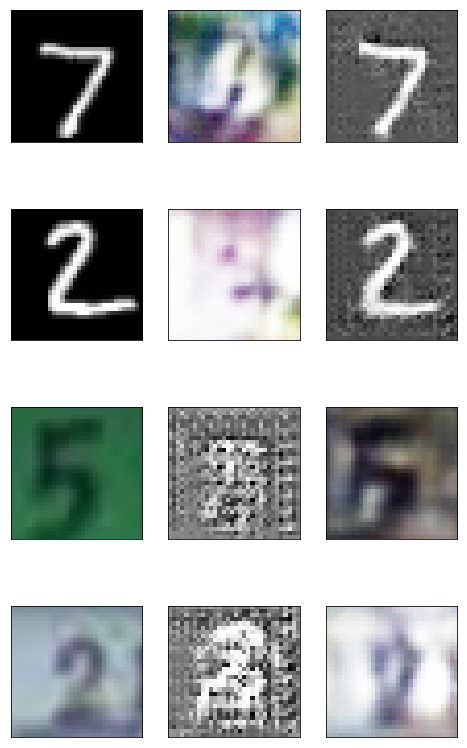

Elapsed [0:12:11.696329], Step [8000/10000], d_real_loss: 0.0189, d_fake_loss: 0.0241, g_loss: 1.0080


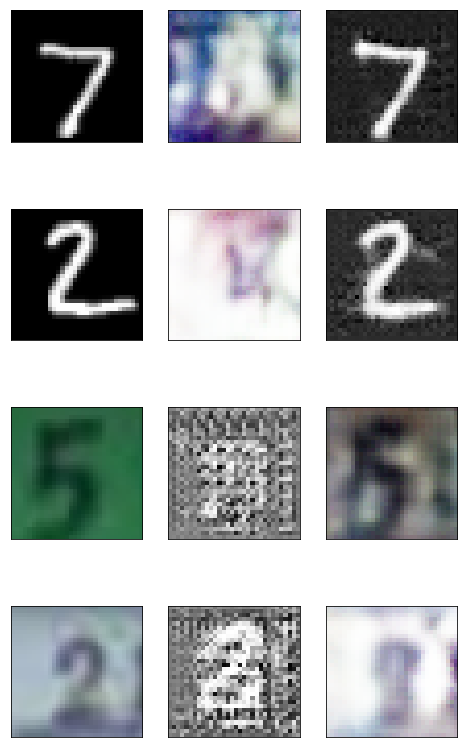

Elapsed [0:13:42.575564], Step [9000/10000], d_real_loss: 0.0400, d_fake_loss: 0.0642, g_loss: 1.0041


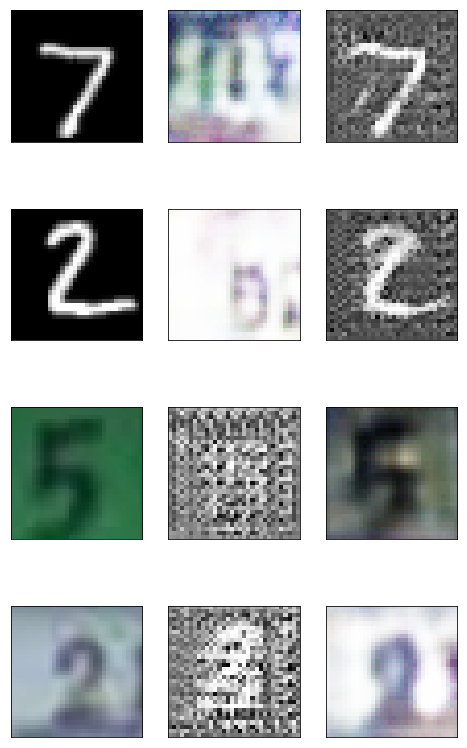

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Elapsed [0:15:14.060654], Step [10000/10000], d_real_loss: 0.0101, d_fake_loss: 0.0036, g_loss: 1.0038


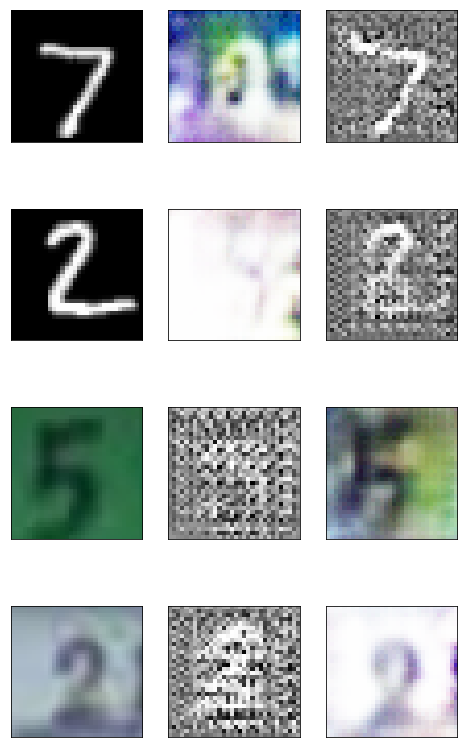

In [0]:
start_time = time.time() # 시간 측정을 위한 변수 

for step in range(iters):
    # 각 도메인의 데이터들을 불러와 줍니다.
    try:
        mnist, m_labels = next(mnist_iter) 
        svhn, s_labels = next(svhn_iter)
    except:
        mnist_iter = iter(mnist_testloader)
        svhn_iter = iter(svhn_testloader)
        mnist, m_labels = next(mnist_iter) 
        svhn, s_labels = next(svhn_iter)
    
    # To GPU
    mnist = mnist.to(device)
    m_labels = m_labels.to(device)
    svhn = svhn.to(device)
    s_labels = s_labels.to(device)
    
    #============ train D ============#

    # Real images를 통해 D를 트레이닝 합니다.
    out = D_m(mnist)
    d_m_loss = torch.mean((out-1)**2)

    out = D_s(svhn)
    d_s_loss = torch.mean((out-1)**2)

    d_real_loss = d_m_loss + d_s_loss
  
    d_optim.zero_grad()
    d_real_loss.backward()
    d_optim.step()

    # Fake images = generated images를 통해 D를 트레이닝 합니다.
    fake_svhn = G_ms(mnist)
    out = D_s(fake_svhn)
    d_m_loss = torch.mean(out**2)

    fake_mnist = G_sm(svhn)
    out = D_m(fake_mnist)
    d_s_loss = torch.mean(out**2)

    d_fake_loss = d_m_loss + d_s_loss
  
    d_optim.zero_grad()
    d_fake_loss.backward()
    d_optim.step()
  
    '''
    Discriminaor는 이제 한 차례 Real image를 1로 fake image를 0으로 분류하도록 학습했습니다. 
    '''

    #============ train G ============#

    # mnist-svhn-mnist cycle loss를 발생 시킵니다.
    fake_svhn = G_ms(mnist)
    out = D_s(fake_svhn)
    recon_mnist = G_sm(fake_svhn)
  
    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있습니다. 
    g_loss += torch.mean((mnist - recon_mnist)**2) # MNIST를 다시 만들어 내야 합니다
  
    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()

    # svhn-mnist-svhn loss를 발생 시킵니다.
    fake_mnist = G_sm(svhn)
    out = D_m(fake_mnist)
    recon_svhn = G_ms(fake_mnist)

    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있습니다.
    g_loss += torch.mean((svhn - recon_svhn)**2) # SVHN를 다시 만들어 내야 합니다

    g_optim.zero_grad()
    g_loss.backward()
    g_optim.step()

    # print the log info
    if (step+1) % 1000 == 0:
        # 걸리는 시간 측정 
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))
    
        # fixed image 로 이미지 생성
        mnist_to_svhn = G_ms(fixed_mnist)
        mnist_recon = G_sm(mnist_to_svhn) 

        svhn_to_mnist = G_sm(fixed_svhn)
        svhn_recon = G_ms(svhn_to_mnist)

        print('======================================================================================================')
        print('Elapsed [%s], Step [%d/%d], d_real_loss: %.4f, d_fake_loss: %.4f, g_loss: %.4f' 
                 % (elapsed, step+1, iters, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
        print('======================================================================================================')
        show_images([fixed_mnist.detach().cpu().numpy(), mnist_to_svhn.detach().cpu().numpy(), mnist_recon.detach().cpu().numpy()
                        ,fixed_svhn.detach().cpu().numpy(), svhn_to_mnist.detach().cpu().numpy(), svhn_recon.detach().cpu().numpy()])
